In [1]:
import gym, random, pickle, os.path, math, glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from torch.distributions import Categorical
import pdb
from baselines import bench
from baselines.common.atari_wrappers import make_atari, wrap_deepmind,LazyFrames
from IPython.display import clear_output
from tensorboardX import SummaryWriter

USE_CUDA = torch.cuda.is_available()

In [2]:
class soft_DQN(nn.Module):
    def __init__(self, num_inputs, num_actions, REWARD_SCALE):
        super(soft_DQN, self).__init__()
        self.REWARD_SCALE = REWARD_SCALE
        self.nn = nn.Sequential(
            nn.Linear(num_inputs, 256),
            nn.ReLU(),
            nn.Linear(256,256),
            nn.ReLU(),
            nn.Linear(256, num_actions)
        )

    def forward(self, x):
        return self.nn(x)
    
    def get_action(self, x):
        action_probs = F.softmax(self.nn(x)/self.REWARD_SCALE,-1)
        action_dist = Categorical(action_probs)
        actions = action_dist.sample().view(-1, 1)
        return actions

In [3]:
class Memory_Buffer(object):
    def __init__(self, memory_size=1000):
        self.buffer = []
        self.memory_size = memory_size
        self.next_idx = 0
        
    def push(self, state, action, reward, next_state, done):
        data = (state, action, reward, next_state, done)
        if len(self.buffer) <= self.memory_size: # buffer not full
            self.buffer.append(data)
        else: # buffer is full
            self.buffer[self.next_idx] = data
        self.next_idx = (self.next_idx + 1) % self.memory_size

    def sample(self, batch_size):
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for i in range(batch_size):
            idx = random.randint(0, self.size() - 1)
            data = self.buffer[idx]
            state, action, reward, next_state, done= data
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(done)
            
            
        return np.concatenate(states), actions, rewards, np.concatenate(next_states), dones
    
    def size(self):
        return len(self.buffer)


In [14]:
class Soft_DQNAgent: 
    def __init__(self, num_inputs = 1, hidden_size = 32,  action_space = [], USE_CUDA = False, memory_size = 10000, lr = 1e-4,reward_scale = 1):
        self.action_space = action_space
        self.memory_buffer = Memory_Buffer(memory_size)
        self.alpha = reward_scale
        self.DQN = soft_DQN(num_inputs = num_inputs, num_actions = action_space.n,REWARD_SCALE = reward_scale)
        self.DQN_target = soft_DQN(num_inputs = num_inputs, num_actions = action_space.n, REWARD_SCALE = reward_scale)
        self.DQN_target.load_state_dict(self.DQN.state_dict())

        self.USE_CUDA = USE_CUDA
        if USE_CUDA:
            self.DQN = self.DQN.cuda()
            self.DQN_target = self.DQN_target.cuda()
        self.optimizer = optim.Adam(self.DQN.parameters(),lr=lr)

    def observe(self, lazyframe):
        # from Lazy frame to tensor
        state =  torch.from_numpy(lazyframe).float().unsqueeze(0)
        if self.USE_CUDA:
            state = state.cuda()
        return state

    def value(self, state):
        q_values = self.DQN(state)
        return q_values
    
    def act(self, state, t, explore_time):
        """
        sample actions with epsilon-greedy policy
        recap: with p = epsilon pick random action, else pick action with highest Q(s,a)
        """
        if t < explore_time:
            action = env.action_space.sample()
        else:
            # Select a random action (when epsilon probability and q_value are the same in that state)
            action = int(self.DQN.get_action(state).squeeze().cpu().detach().numpy())
        return action

    def compute_td_loss(self, states, actions, rewards, next_states, is_done, gamma=0.99):
        """ Compute td loss using torch operations only. Use the formula above. """
        #pdb.set_trace()
        actions = torch.tensor(actions).long()    # shape: [batch_size]
        rewards = torch.tensor(rewards, dtype =torch.float)  # shape: [batch_size]
        is_done = torch.tensor(is_done).bool()  # shape: [batch_size]
        
        if self.USE_CUDA:
            actions = actions.cuda()
            rewards = rewards.cuda()
            is_done = is_done.cuda()

        # get q-values for all actions in current states
        q_values  = self.DQN(states)

        # select q-values for chosen actions
        qvalues_for_actions = q_values[range(states.shape[0]), actions]

        # compute q-values for all actions in next states 
        ## DQN
        predicted_next_qvalues = self.DQN_target(next_states) # YOUR CODE
        # compute V*(next_states) using predicted next q-values
        next_state_values =  self.alpha*torch.logsumexp(predicted_next_qvalues/self.alpha, dim = -1) # YOUR CODE        

        # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
        target_qvalues_for_actions = rewards + gamma*next_state_values # YOUR CODE

        # at the last state we shall use simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
        #target_qvalues_for_actions = torch.where(
        #    is_done, rewards, target_qvalues_for_actions)

        # mean squared error loss to minimize
        #loss = torch.mean((qvalues_for_actions -
        #                   target_qvalues_for_actions.detach()) ** 2)
        td_error = (target_qvalues_for_actions - qvalues_for_actions)
        loss = F.mse_loss(qvalues_for_actions, target_qvalues_for_actions.detach())
        
        ## Update
        self.optimizer.zero_grad()
        loss.backward()
        # for param in self.DQN.parameters():
        #     nn.utils.clip_grad_norm_(param, 100)

        # for param in self.DQN.parameters():
        #     param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
        
        # calculate some values
        with torch.no_grad():
            q_values_full = q_values.detach().clone()
            q_values_full[range(states.shape[0]), actions] = q_values_full[range(states.shape[0]), actions]+  td_error 
            v_new = self.alpha*torch.logsumexp(q_values_full/self.alpha, dim = -1)
            policy_new = F.softmax(q_values_full/self.alpha, dim = -1)
            v_old = self.alpha*torch.logsumexp(q_values/self.alpha, dim = -1)
            policy_old = F.softmax(q_values/self.alpha, dim = -1)
            policy_max = torch.max(policy_new[range(states.shape[0]),actions], policy_old[range(states.shape[0]),actions])

        ## Recording errors and 
        
        td_errors.append((policy_max*td_error).squeeze().detach().cpu().numpy())
        # value
        EVBs.append((v_new -v_old).detach().cpu().numpy())
        EIVs.append((v_new -v_old-policy_old[range(states.shape[0]),actions]*td_error).detach().cpu().numpy())
        PIVs.append(EVBs[-1] - EIVs[-1])
        
        return loss
    
    def sample_from_buffer(self, batch_size):
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for i in range(batch_size):
            idx = random.randint(0, self.memory_buffer.size() - 1)
            data = self.memory_buffer.buffer[idx]
            frame, action, reward, next_frame, done= data
            states.append(self.observe(frame))
            actions.append(action)
            rewards.append(reward)
            next_states.append(self.observe(next_frame))
            dones.append(done)
        return torch.cat(states), actions, rewards, torch.cat(next_states), dones

    def learn_from_experience(self, batch_size):
        if self.memory_buffer.size() > batch_size:
            states, actions, rewards, next_states, dones = self.sample_from_buffer(batch_size)
            td_loss = self.compute_td_loss(states, actions, rewards, next_states, dones)
            return(td_loss.item())
        else:
            return(0)
    

In [15]:
# if __name__ == '__main__':
    
# Training DQN in PongNoFrameskip-v4 
env = gym.make('CartPole-v0')
reward_scale = 1/4
gamma = 0.99
frames = 50000
explore_time = 5000
USE_CUDA = True
learning_rate = 5e-4
max_buff = 1000
batch_size = 16
print_interval = 1000
log_interval = 1000
learning_start = 1000
update_current_step =1 # update current model every 4 steps
win_reward = 18     # Pong-v4
win_break = True

action_space = env.action_space
action_dim = env.action_space.n
state_dim = env.observation_space.shape[0]
agent = Soft_DQNAgent(num_inputs = state_dim,action_space= action_space, USE_CUDA = USE_CUDA, lr = learning_rate,
                      memory_size = max_buff, reward_scale = reward_scale)

frame = env.reset()

episode_reward = 0
all_rewards = []
losses = []
episode_num = 0
is_win = False
# tensorboard
summary_writer = SummaryWriter(log_dir = "DQN_CartPole", comment= "good_makeatari")


# Recordings
# value
PIVs = []
EIVs = []
EVBs = []
# consumption
policy_ivs_ece = []
value_ivs_ece = []
eces = []
# residual value = value - consumption
policy_ivs_erve = []
value_ivs_erve = []
erves = []
# td error
td_errors = []

for i in range(frames):
    state_tensor = agent.observe(frame)
    action = agent.act(state_tensor, i, learning_start)
    
    next_frame, reward, is_done, _ = env.step(action)
    reward = -5 if is_done and episode_reward != 199 else reward
    episode_reward += reward
    agent.memory_buffer.push(frame, action, reward, next_frame, is_done)
    frame = next_frame
    
    loss = 0
    if agent.memory_buffer.size() >= learning_start:
        if i % update_current_step == 0:
            loss = agent.learn_from_experience(batch_size)
            losses.append(loss)

    if i % print_interval == 0:
        print("frames: %5d, reward: %5f, loss: %4f,  episode: %4d" % (i, np.mean(all_rewards[-10:]), loss, episode_num))
        summary_writer.add_scalar("Temporal Difference Loss", loss, i)
        summary_writer.add_scalar("Mean Reward", np.mean(all_rewards[-10:]), i)
        
    
    if is_done:
        agent.DQN_target.load_state_dict(agent.DQN.state_dict())
        frame = env.reset()
        
        all_rewards.append(episode_reward)
        episode_reward = 0
        episode_num += 1
        avg_reward = float(np.mean(all_rewards[-100:]))

summary_writer.close()

frames:     0, reward:   nan, loss: 0.000000,  episode:    0
frames:  1000, reward: 14.500000, loss: 2.532547,  episode:   48
frames:  2000, reward: 64.600000, loss: 0.234972,  episode:   78
frames:  3000, reward: 150.800000, loss: 0.031703,  episode:   84
frames:  4000, reward: 153.000000, loss: 0.027064,  episode:   90
frames:  5000, reward: 165.900000, loss: 0.011435,  episode:   96
frames:  6000, reward: 112.400000, loss: 0.125064,  episode:  105
frames:  7000, reward: 138.300000, loss: 0.015725,  episode:  110
frames:  8000, reward: 176.800000, loss: 0.134193,  episode:  116
frames:  9000, reward: 173.300000, loss: 0.014371,  episode:  122
frames: 10000, reward: 105.500000, loss: 0.040891,  episode:  131
frames: 11000, reward: 98.500000, loss: 0.103300,  episode:  141
frames: 12000, reward: 72.400000, loss: 0.230516,  episode:  152
frames: 13000, reward: 116.100000, loss: 0.061538,  episode:  160
frames: 14000, reward: 119.600000, loss: 2.711951,  episode:  168
frames: 15000, rewa

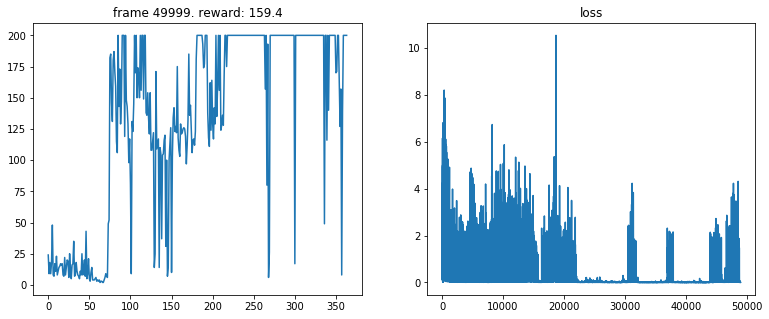

In [16]:
def plot_training(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

plot_training(i, all_rewards, losses)

In [17]:
td_errors = np.array(td_errors).flatten()
EVBs = np.array(EVBs).flatten()
EIVs = np.array(EIVs).flatten()
PIVs = np.array(PIVs).flatten()


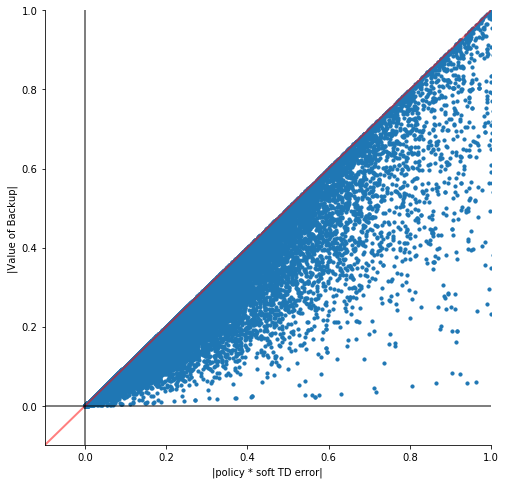

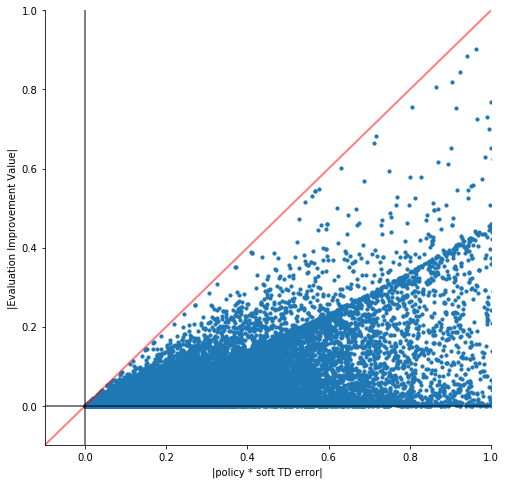

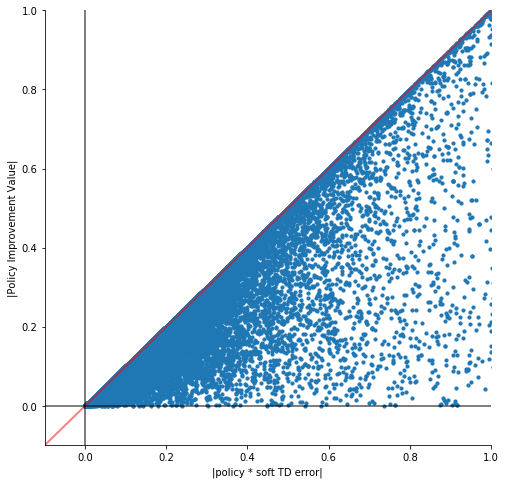

In [59]:
plt.figure()
sample_ind = np.random.randint(0, len(td_errors),100000)
plotlim = 1
plt.scatter(np.abs(td_errors[sample_ind]), np.abs(eves[sample_ind]), s = 10)
plt.xlabel('|policy * soft TD error|')
plt.ylabel('|Value of Backup|')
plt.xlim(-0.1,plotlim)
plt.ylim(-0.1,plotlim)
plt.plot([-plotlim,plotlim], [-plotlim,plotlim], color = 'red', linewidth = 2, alpha = 0.5)
plt.plot([-1,1], [0,0], color = 'black', linewidth = 2, alpha = 0.5)
plt.plot([0,0], [-1,1], color = 'black', linewidth = 2, alpha = 0.5)
fig = plt.gcf()
[ax1] = fig.axes
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
fig.set_size_inches(8,8)
fig.savefig('figure/soft_dqn_cartpole_evb_bound.png', dpi=100)
fig.savefig('figure/soft_dqn_cartpole_evb_bound.eps', dpi=100)
plt.show()

plt.scatter(np.abs(td_errors[sample_ind]), np.abs(value_ivs_eve[sample_ind]), s = 10)
plt.xlabel('|policy * soft TD error|')
plt.ylabel('|Evaluation Improvement Value|')
plt.xlim(-0.1,plotlim)
plt.ylim(-0.1,plotlim)
plt.plot([-plotlim,plotlim], [-plotlim,plotlim], color = 'red', linewidth = 2, alpha = 0.5)
plt.plot([-1,1], [0,0], color = 'black', linewidth = 2, alpha = 0.5)
plt.plot([0,0], [-1,1], color = 'black', linewidth = 2, alpha = 0.5)
fig = plt.gcf()
[ax1] = fig.axes
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
fig.set_size_inches(8,8)
fig.savefig('figure/soft_dqn_cartpole_eiv_bound.png', dpi=100)
fig.savefig('figure/soft_dqn_cartpole_eiv_bound.eps', dpi=100)

plt.show()

plt.scatter(np.abs(td_errors[sample_ind]), np.abs(policy_ivs_eve[sample_ind]), s = 10)
plt.xlabel('|policy * soft TD error|')
plt.ylabel('|Policy Improvement Value|')
plt.xlim(-0.1,plotlim)
plt.ylim(-0.1,plotlim)
plt.plot([-plotlim,plotlim], [-plotlim,plotlim], color = 'red', linewidth = 2, alpha = 0.5)
plt.plot([-1,1], [0,0], color = 'black', linewidth = 2, alpha = 0.5)
plt.plot([0,0], [-1,1], color = 'black', linewidth = 2, alpha = 0.5)
fig = plt.gcf()
[ax1] = fig.axes
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
fig.set_size_inches(8,8)
fig.savefig('figure/soft_dqn_cartpole_piv_bound.png', dpi=100)
fig.savefig('figure/soft_dqn_cartpole_piv_bound.eps', dpi=100)

plt.show()


In [60]:
import pickle
# save file to pickle
result_data = {"td": td_errors, "evb": eves, "piv": policy_ivs_eve, "eiv": value_ivs_eve,  "episode_rewards":all_rewards}
with open('results/cartpole_soft_dqn.pickle', 'wb') as handle:
    pickle.dump(result_data, handle)
